# Result_Fig3_2 : Difficulty with Tag Availability

In [1]:
import sys, os
p = os.path.abspath('..')
pp = os.path.abspath('../..')

sys.path.insert(1, p)
sys.path.insert(1, pp)



In [ ]:
from utils.statistics import *
from utils.settings import *

from constants import CONSTANTS

import numpy as np
import pandas as pd
import json
import itertools
import seaborn as sns
import datetime


import matplotlib.pyplot as plt
colors = plt.get_cmap('tab20').colors 



In [3]:
input_dir = f'{CONSTANTS.data_availability_dir}/result/bert_based/difficulty_annotated/data'
output_dir = './fig/'
date_range = 'Daily'

tag_info = load_json(f"{CONSTANTS.data_availability_dir}/result/tag/tag_info.json")
all_tags = list(tag_info.keys())

In [4]:
diff_dict = {'0':'Basic', '1':'Intermediate', '2':'Advanced'}

In [5]:
tot_df = pd.DataFrame()
for f in os.listdir(input_dir):
    js = load_json(f'{input_dir}/{f}')
    df = pd.DataFrame(js)
    tot_df = pd.concat([tot_df, df], axis=0)

In [6]:
tot_df.head()

,id,creationdate,title,tags,body,Document,Topic,difficulty
0,77011759,2023-08-30 22:01:13.597000,Math domain error when simplifying radicals,<python><math><square-root>,<p>I am attempting to create a function in Pyt...,I am attempting to create a function in Python...,15,0
1,77011809,2023-08-30 22:11:25.720000,Debian 11 : pip is configured with locations t...,<python><ssl><installation><pip><pyenv>,<p>I've installed Python 3.11 in Debian 11 but...,I've installed Python 3.11 in Debian 11 but af...,29,2
2,77012106,2023-08-30 23:39:49.527000,Django Allauth - ModuleNotFoundError: No modul...,<python><python-3.x><django><django-allauth><d...,<p>&quot;ModuleNotFoundError: No module named ...,""";ModuleNotFoundError: No module named 'allaut...",12,1
3,77012115,2023-08-30 23:42:26.333000,Using plotly express px.bar causes a shift in ...,<python><time-series><plotly><bar-chart><plotl...,<p>I am trying to print a bar chart using plot...,I am trying to print a bar chart using plotly ...,1,0
4,77008560,2023-08-30 13:36:10.017000,How to make Kivy app stay in the Task Bar on c...,<python><kivy>,<p>How to make the Kivy app stay in the Task B...,How to make the Kivy app stay in the Task Bar ...,7,1


In [7]:
tot_t_list = tot_df[['id', 'creationdate', 'difficulty', 'tags']].copy()
tot_t_list.loc[:, 'tags_list'] = tot_t_list['tags'].apply(lambda x : x.replace('><', ' ').replace('<', '').replace('>', '').split(' '))
tot_t_list['tags_list'] = tot_t_list['tags_list'].apply(lambda x : list(itertools.product((x), repeat=2)))
tot_t_list['tags_list'] = tot_t_list['tags_list'].apply(lambda x :sorted(x))

In [8]:
# diff_t_list = 
tot_t_list = tot_t_list.explode('tags_list')

In [9]:
tot_t_list['tags_for_n'] = tot_t_list['tags_list'].apply(lambda x : '' if x[0]==x[1] else x)

In [10]:
tot_t_list = tot_t_list[tot_t_list['tags_for_n'] != ''].reset_index(drop=True)

In [11]:
tot_t_list.head()

,id,creationdate,difficulty,tags,tags_list,tags_for_n
0,77011759,2023-08-30 22:01:13.597000,0,<python><math><square-root>,"(math, python)","(math, python)"
1,77011759,2023-08-30 22:01:13.597000,0,<python><math><square-root>,"(math, square-root)","(math, square-root)"
2,77011759,2023-08-30 22:01:13.597000,0,<python><math><square-root>,"(python, math)","(python, math)"
3,77011759,2023-08-30 22:01:13.597000,0,<python><math><square-root>,"(python, square-root)","(python, square-root)"
4,77011759,2023-08-30 22:01:13.597000,0,<python><math><square-root>,"(square-root, math)","(square-root, math)"


In [12]:
tot_t_list['rel_week'] = np.floor((pd.to_datetime(tot_t_list['creationdate'], format='mixed')- datetime.datetime(2022,11,30)).dt.days/7)

In [13]:
tot_t_list = tot_t_list[(tot_t_list['rel_week']>-53) & (tot_t_list['rel_week']<52)]

In [14]:
tot_t_list['gpt_yn'] = np.where(tot_t_list['rel_week']<0, 0, 1)

In [15]:
import networkx as nx
def make_network(tag_for_n_list) : 
    G = nx.Graph()
    G.add_edges_from(tag_for_n_list)
    return G

In [16]:
g_yn_dict = dict()
for diff in diff_dict.keys():
    g_yn_dict[diff] = dict()
    tmp = tot_t_list[tot_t_list['difficulty'] == diff]
    for yn in tmp['gpt_yn'].unique():
        tmp2 = tmp[tmp['gpt_yn'] == yn]
        g_yn_dict[diff][yn] = make_network([x for x in tmp2['tags_for_n']])
        

In [17]:
def calc_entropy_contributions(G):
    degrees = np.array([degree for _, degree in G.degree()])
    degree_sum = degrees.sum()
    p = degrees / degree_sum
    entropy_contributions = - p * np.log(p)
    node_names = [node for node, _ in G.degree()]
    return dict(zip(node_names, entropy_contributions))

In [18]:
b_dict = dict()
a_dict = dict()
d_dict = dict()
for diff in diff_dict.keys():
    b_dict[diff] = calc_entropy_contributions(g_yn_dict[diff][0])
    a_dict[diff] = calc_entropy_contributions(g_yn_dict[diff][1])

    d_dict[diff] = {node: a_dict[diff].get(node, 0) - b_dict[diff].get(node, 0)
        for node in set(list(b_dict[diff].keys()) + list(a_dict[diff].keys()))}


In [19]:
value_dict = dict()

for idx, diff in enumerate(diff_dict.keys()):
    all_nodes           = len(list(set(b_dict[diff].keys()).union(a_dict[diff].keys())))
    new_nodes           = len(set(a_dict[diff].keys()) - set(b_dict[diff].keys()))
    disapperaed_nodes   = len(set(b_dict[diff].keys()) - set(a_dict[diff].keys()))
    
    new_ratio           = new_nodes/all_nodes
    disapperaed_ratio   = disapperaed_nodes/all_nodes
    remain_ratio        = 1- new_ratio - disapperaed_ratio

    value_dict[diff] = [new_ratio,disapperaed_ratio, remain_ratio]




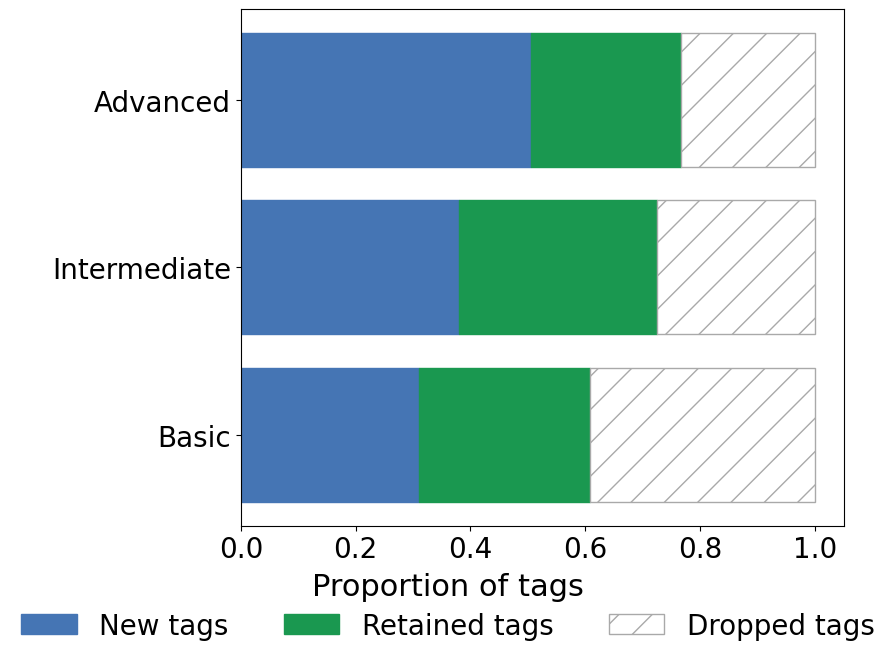

In [20]:
categories = list(diff_dict.keys())  
new = [value_dict[x][0] for x in diff_dict.keys()]
gone = [value_dict[x][1] for x in diff_dict.keys()]
left = [value_dict[x][2] for x in diff_dict.keys()]


fig, ax = plt.subplots(figsize=(8, 6), constrained_layout=True)


ax.barh(categories, new, label='New tags', color="#4575b4", edgecolor="#4575b4")
ax.barh(categories, left, left=new, label='Retained tags', color="#1a9850", edgecolor="#1a9850")


left_sum = [v1 + v2 for v1, v2 in zip(new, left)]
ax.barh(categories, gone, left=left_sum, label='Dropped tags', color='white', edgecolor='#A9A9A9', hatch='/')
ax.set_yticks([0, 1, 2])
ax.set_yticklabels([f'{x}' for x in list(diff_dict.values())], ha='right')  # 원하는 텍스트로 바꾸기


ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)

fig.supxlabel('Proportion of tags', fontsize=22)

handles, labels = ax.get_legend_handles_labels()
fig.legend(
    handles=handles,
    labels=labels,
    loc='lower center',
    bbox_to_anchor=(0.5, -0.1),
    ncol=4,
    fontsize=20,
    frameon=False
)


plt.savefig(f"{output_dir}C_Result_Fig3_2.png", dpi=300, bbox_inches='tight')
# 그래프 보여주기
plt.show()
